1. Mempersiapkan semua pustaka yang diperlukan untuk analisis, mencakup manipulasi data, visualisasi, preprocessing, dan evaluasi model.

In [11]:
# Import Library
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


2. Memuat dataset utama dan menampilkan 5 baris pertama untuk mendapatkan gambaran umum data.

In [12]:
# Load Dataset
data_path = "../data/raw/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data_path)

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


3. Membersihkan data (imputasi nilai kosong, encoding kategorikal).
   Normalisasi data numerik.
   Menangani ketidakseimbangan kelas dengan SMOTE.

In [13]:

df = pd.read_csv(data_path)

# Preprocessing
df = df.copy()  # Membuat salinan untuk diproses

# Imputasi untuk kolom numerik dengan Rata-rata
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
numerical_imputer = SimpleImputer(strategy='mean')  # Imputasi dengan rata-rata
df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])

# Imputasi untuk kolom kategorikal dengan Modus
categorical_features = df.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Isi dengan nilai yang paling sering muncul
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Verifikasi apakah ada nilai yang hilang
print("Jumlah nilai yang hilang setelah imputasi:\n", df.isnull().sum())  # Tidak ada nilai yang hilang setelah imputasi

# Encoding categorical features
label_encoder = LabelEncoder()
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])

# Splitting features and target
if 'id' in df.columns and 'stroke' in df.columns:
    X = df.drop(columns=['id', 'stroke'])
    y = df['stroke']
else:
    print("Kolom 'id' atau 'stroke' tidak ditemukan. Pastikan kolom tersebut ada.")
    X, y = df, None  # Jika kolom tidak ada, tidak lanjutkan

# Verifikasi ukuran X dan y
print(f"Ukuran X: {X.shape}, Ukuran y: {y.shape}")

# Normalize numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Oversample minority class using SMOTE
if y is not None:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    print("Target 'y' tidak ditemukan, tidak bisa melanjutkan dengan SMOTE.")

# Save the preprocessed data
if 'X_resampled' in locals() and 'y_resampled' in locals():
    preprocessed_data = pd.DataFrame(X_resampled, columns=X.columns)  # Kolom fitur
    preprocessed_data['stroke'] = y_resampled  # Menambahkan target 'stroke'

    # Save the preprocessed dataset to a CSV file
    preprocessed_data.to_csv("../data/processed/healthcare_data_preprocessed.csv", index=False)

    print("Preprocessing selesai dan data telah disimpan.")
else:
    print("Proses preprocessing gagal.")


Jumlah nilai yang hilang setelah imputasi:
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Ukuran X: (5110, 10), Ukuran y: (5110,)
Preprocessing selesai dan data telah disimpan.


4.  Dataset terbagi dengan rasio 80:20.
    80 data training dan 20 data pengujian.

In [14]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [15]:
# Initialize models
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()

# Hyperparameter tuning for KNN
param_grid = {'n_neighbors': range(3, 21, 2)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors for KNN: {best_k}")

# Train models with optimal parameters
naive_bayes.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)


Optimal number of neighbors for KNN: 3


KNeighborsClassifier(n_neighbors=3)

In [16]:
# Predictions
y_pred_nb = naive_bayes.predict(X_test)
y_pred_knn = knn.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    return cm, acc, prec, rec, f1

# Evaluate Naïve Bayes
cm_nb, acc_nb, prec_nb, rec_nb, f1_nb = evaluate_model(y_test, y_pred_nb, "Naïve Bayes")

# Evaluate K-Nearest Neighbor
cm_knn, acc_knn, prec_knn, rec_knn, f1_knn = evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbor")


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       975
         1.0       0.74      0.81      0.78       970

    accuracy                           0.77      1945
   macro avg       0.77      0.77      0.76      1945
weighted avg       0.77      0.77      0.76      1945


KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91       975
         1.0       0.86      0.99      0.92       970

    accuracy                           0.92      1945
   macro avg       0.93      0.92      0.92      1945
weighted avg       0.93      0.92      0.92      1945

--- Naïve Bayes ---
Confusion Matrix:
 [[698 277]
 [180 790]]
Accuracy: 0.77
Precision: 0.74
Recall: 0.81
F1-Score: 0.78

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       975
         1.0       0.74     

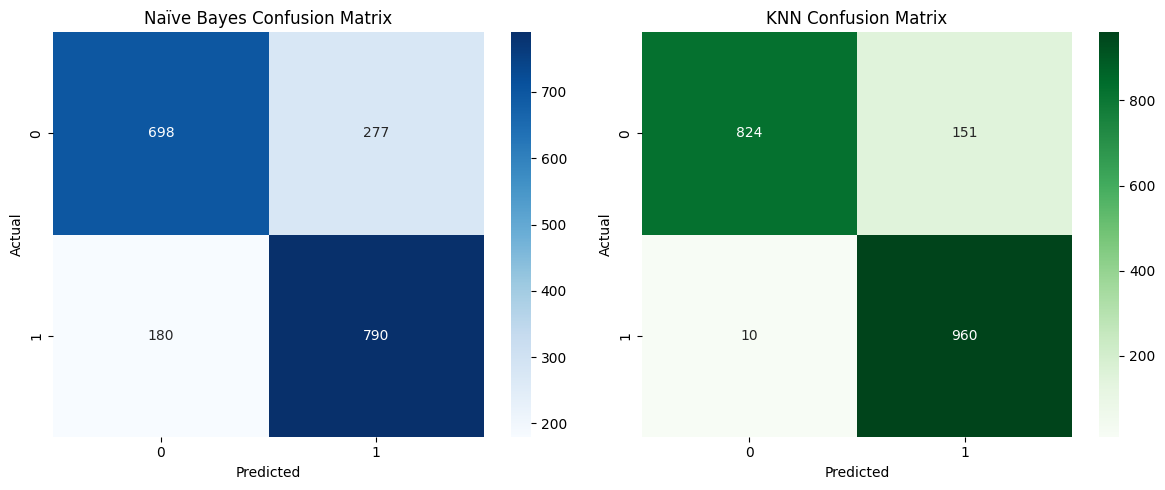

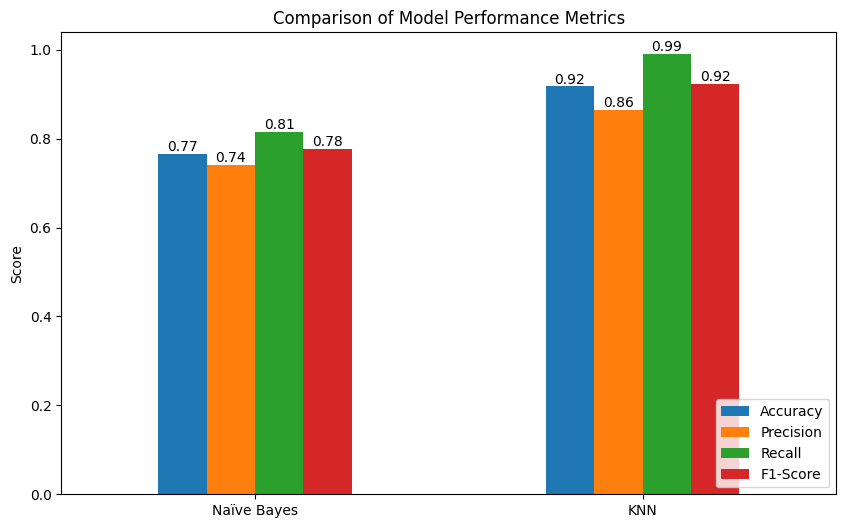

In [17]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Naïve Bayes Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("KNN Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Comparison of Metrics
metrics = {
    "Accuracy": [acc_nb, acc_knn],
    "Precision": [prec_nb, prec_knn],
    "Recall": [rec_nb, rec_knn],
    "F1-Score": [f1_nb, f1_knn]
}

metrics_df = pd.DataFrame(metrics, index=["Naïve Bayes", "KNN"])
ax = metrics_df.plot(kind="bar", figsize=(10, 6), legend=True)
plt.title("Comparison of Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")

# Add text annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')  # Display the value with 2 decimal points

plt.show()
